# Label Exploration

## Imports

In [3]:
import csv
from os import listdir
from os.path import exists

from scipy import stats
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

### Read in HBN label CSV

In [4]:
label_file_path = r'/imaging3/owenlab/bpho/Biobank Labels/Labels_Feb2_2021.csv'
labels = pd.read_csv(label_file_path, index_col='Identifiers', dtype='str')
label_subject_ids = labels['assessment WISC,EID']

print(f'Number of subjects with labels: {label_subject_ids.nunique()}')

FileNotFoundError: [Errno 2] No such file or directory: '/imaging3/owenlab/bpho/Biobank Labels/Labels_Feb2_2021.csv'

### Read in subject IDs with FC

In [5]:
data_subject_ids = set()

for age in range(5, 19):
    age_dir = f'/imaging3/owenlab/bpho/python_power_fc/Age{age}'
    
    if not exists(age_dir):
        continue
    
    curr_age_subjects = {folder[4:] for folder in listdir(age_dir) if folder.startswith("sub-")}
    data_subject_ids = data_subject_ids.union(curr_age_subjects)

data = pd.DataFrame(data_subject_ids, columns=['subject_id']).set_index('subject_id')
# display(data)
print(f'Number of subjects with FC: {len(data_subject_ids)}')

Number of subjects with FC: 825


## Clean labels

### Filter for age and WISC columns

In [6]:
demographics = labels[['assessment Basic_Demos,Sex', 'assessment Basic_Demos,Age',
                       'assessment Diagnosis_ClinicianConsensus,NoDX',
                       'assessment Diagnosis_ClinicianConsensus,DX_01']]

wisc_labels = labels.filter(like="WISC").join(demographics)
wisc_labels = wisc_labels[wisc_labels['assessment WISC,WISC_complete'] == '1']
wisc_labels = wisc_labels.set_index("assessment WISC,EID")
# display(wisc_labels)
print(f'Number of subjects with complete WISC: {len(wisc_labels)}')

Number of subjects with complete WISC: 2751


### Get the list of bad subjects and remove them

In [2]:
from common.paths import BAD_SUBJECTS

bad_subjects = pd.read_csv(BAD_SUBJECTS, index_col='subject_id')
# display(bad_subjects)
print("Number of bad subjects:", len(bad_subjects))

clean_labels = wisc_labels[~wisc_labels.index.isin(bad_subjects.index)]
# display(clean_labels)
print("Number of clean subjects:", len(clean_labels))

ImportError: cannot import name 'BAD_SUBJECTS' from 'common.paths' (/home/bpho/Documents/MSc_Research-Project/src/common/paths.py)

### Filter for subjects with FC data

In [9]:
subjects_with_labels = clean_labels.merge(data, left_index=True, right_index=True)
subjects_with_labels.index.rename("assessment WISC,EID", inplace=True)
# display(subjects_with_labels)
print(f'Number of subjects with labels + FC: {len(subjects_with_labels)}')
print(f'Number of labels: {len(subjects_with_labels.columns)}')
# print(subjects_with_labels.columns)

Number of subjects with labels + FC: 678
Number of labels: 55


### Clean up diagnosis column and filter for subjects with diagnosis

In [12]:
given_diagnosis = subjects_with_labels['assessment Diagnosis_ClinicianConsensus,NoDX']

# 1= No, 2= Yes, 3= Dropped out of study before diagnosis was given
diagnosis_key = {'1': 'No', '2': 'Yes', '3': 'Unknown', '.': 'Unknown'}
subjects_with_labels['assessment Diagnosis_ClinicianConsensus,NoDX'] = given_diagnosis.replace(diagnosis_key)
subjects_with_labels = subjects_with_labels[subjects_with_labels['assessment Diagnosis_ClinicianConsensus,NoDX'] == 'Yes']
subjects_with_labels.drop(subjects_with_labels[subjects_with_labels['assessment Diagnosis_ClinicianConsensus,DX_01'] == ' '].index, inplace=True)
subjects_with_labels.drop(subjects_with_labels[subjects_with_labels['assessment Diagnosis_ClinicianConsensus,DX_01'] == '.'].index, inplace=True)

print(f'Number of subjects with labels + FC: {len(subjects_with_labels)}')

Number of subjects with labels + FC: 594


## Write labels to CSV

In [13]:
subjects_with_labels = subjects_with_labels.drop_duplicates()
csv_output_path = "/imaging3/owenlab/bpho/Biobank Labels/Subjects_with_WISC.csv"
subjects_with_labels.to_csv(csv_output_path)

print(f'Number of subjects with labels + FC: {len(subjects_with_labels)}')

Number of subjects with labels + FC: 594


## Plot label distribution

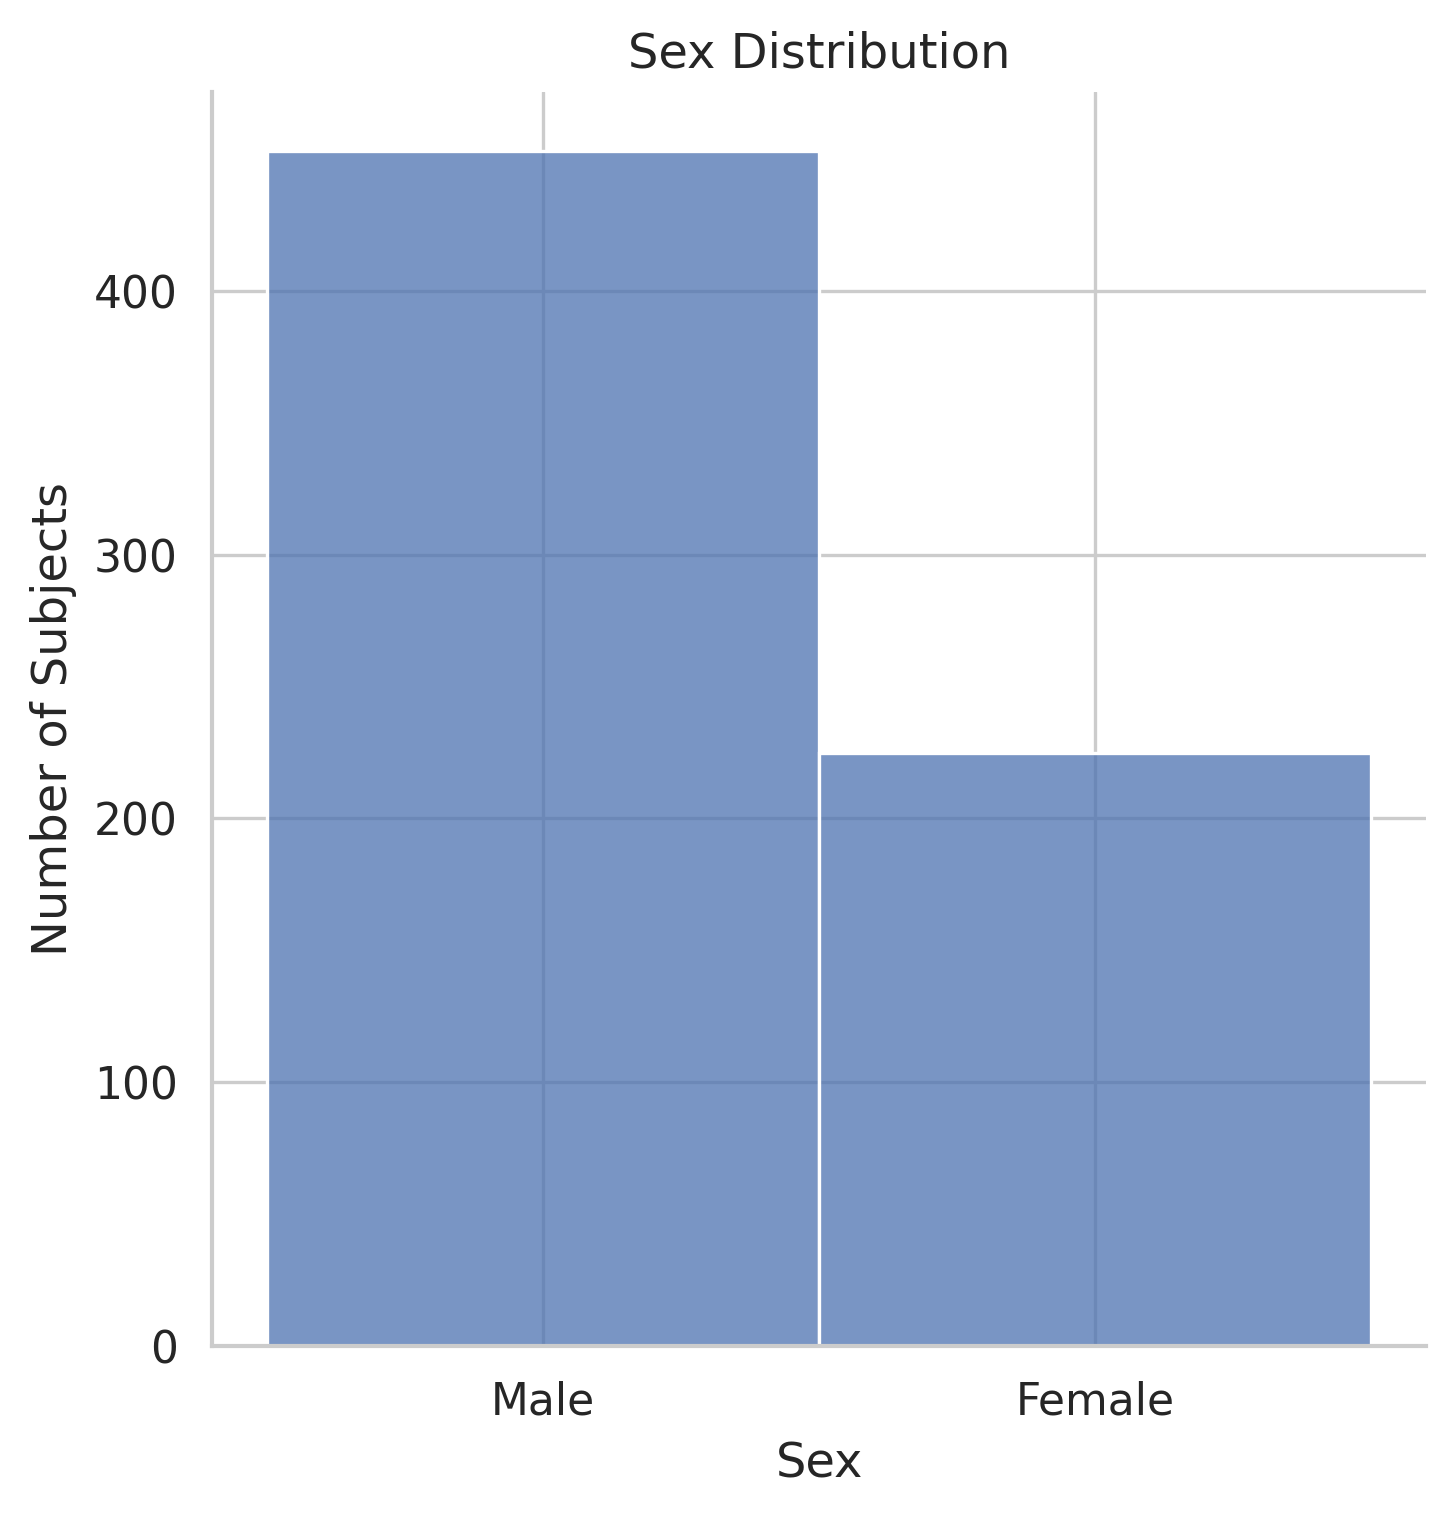

In [9]:
sex_key = {'0': 'Male', '1': 'Female'}
sex = subjects_with_labels['assessment Basic_Demos,Sex'].replace(sex_key)

sns.displot(x=sex)
plt.title("Sex Distribution")
plt.xlabel('Sex')
plt.ylabel('Number of Subjects')
plt.show()

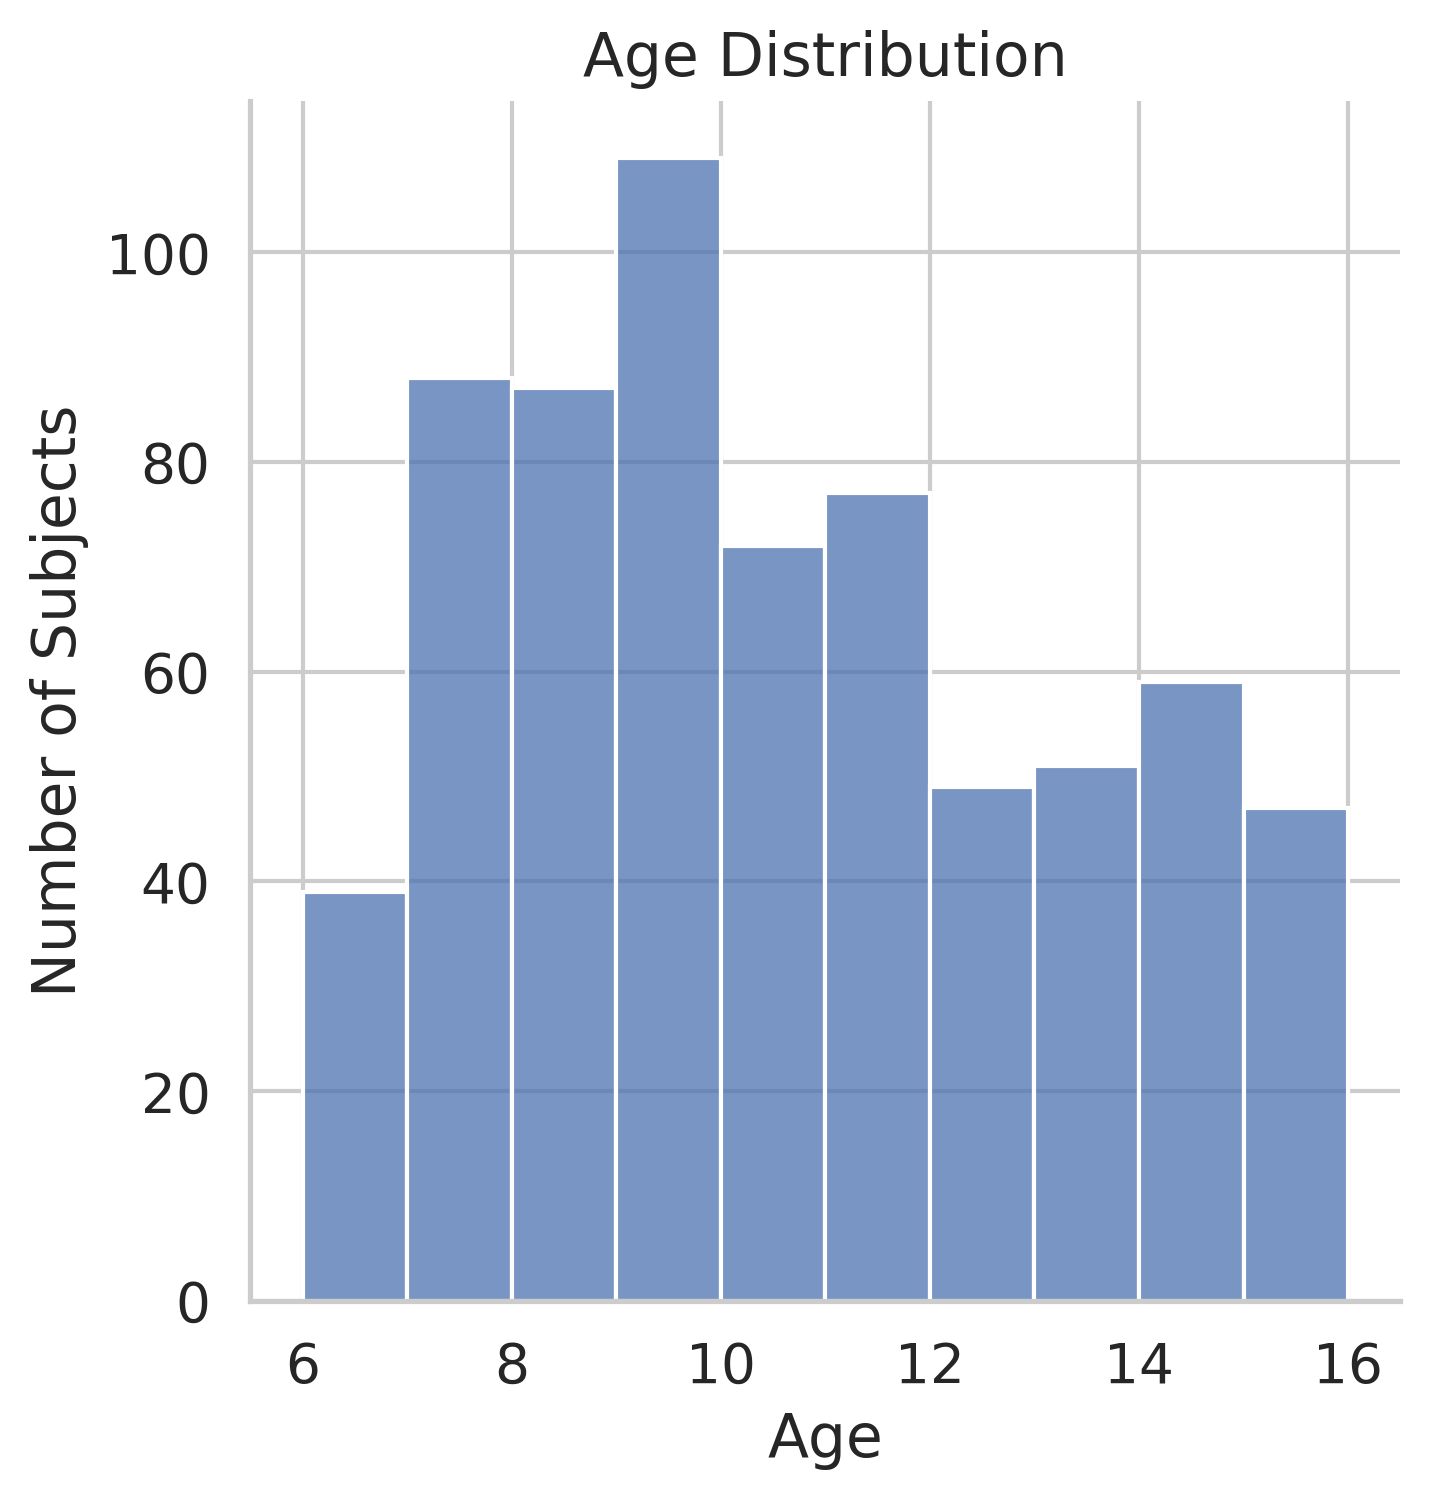

In [24]:
sns.displot(x=subjects_with_labels['assessment Basic_Demos,Age'].astype(float), bins=range(6, 17, 1))
plt.title("Age Distribution")
plt.xlabel('Age')
plt.ylabel('Number of Subjects')
plt.show()

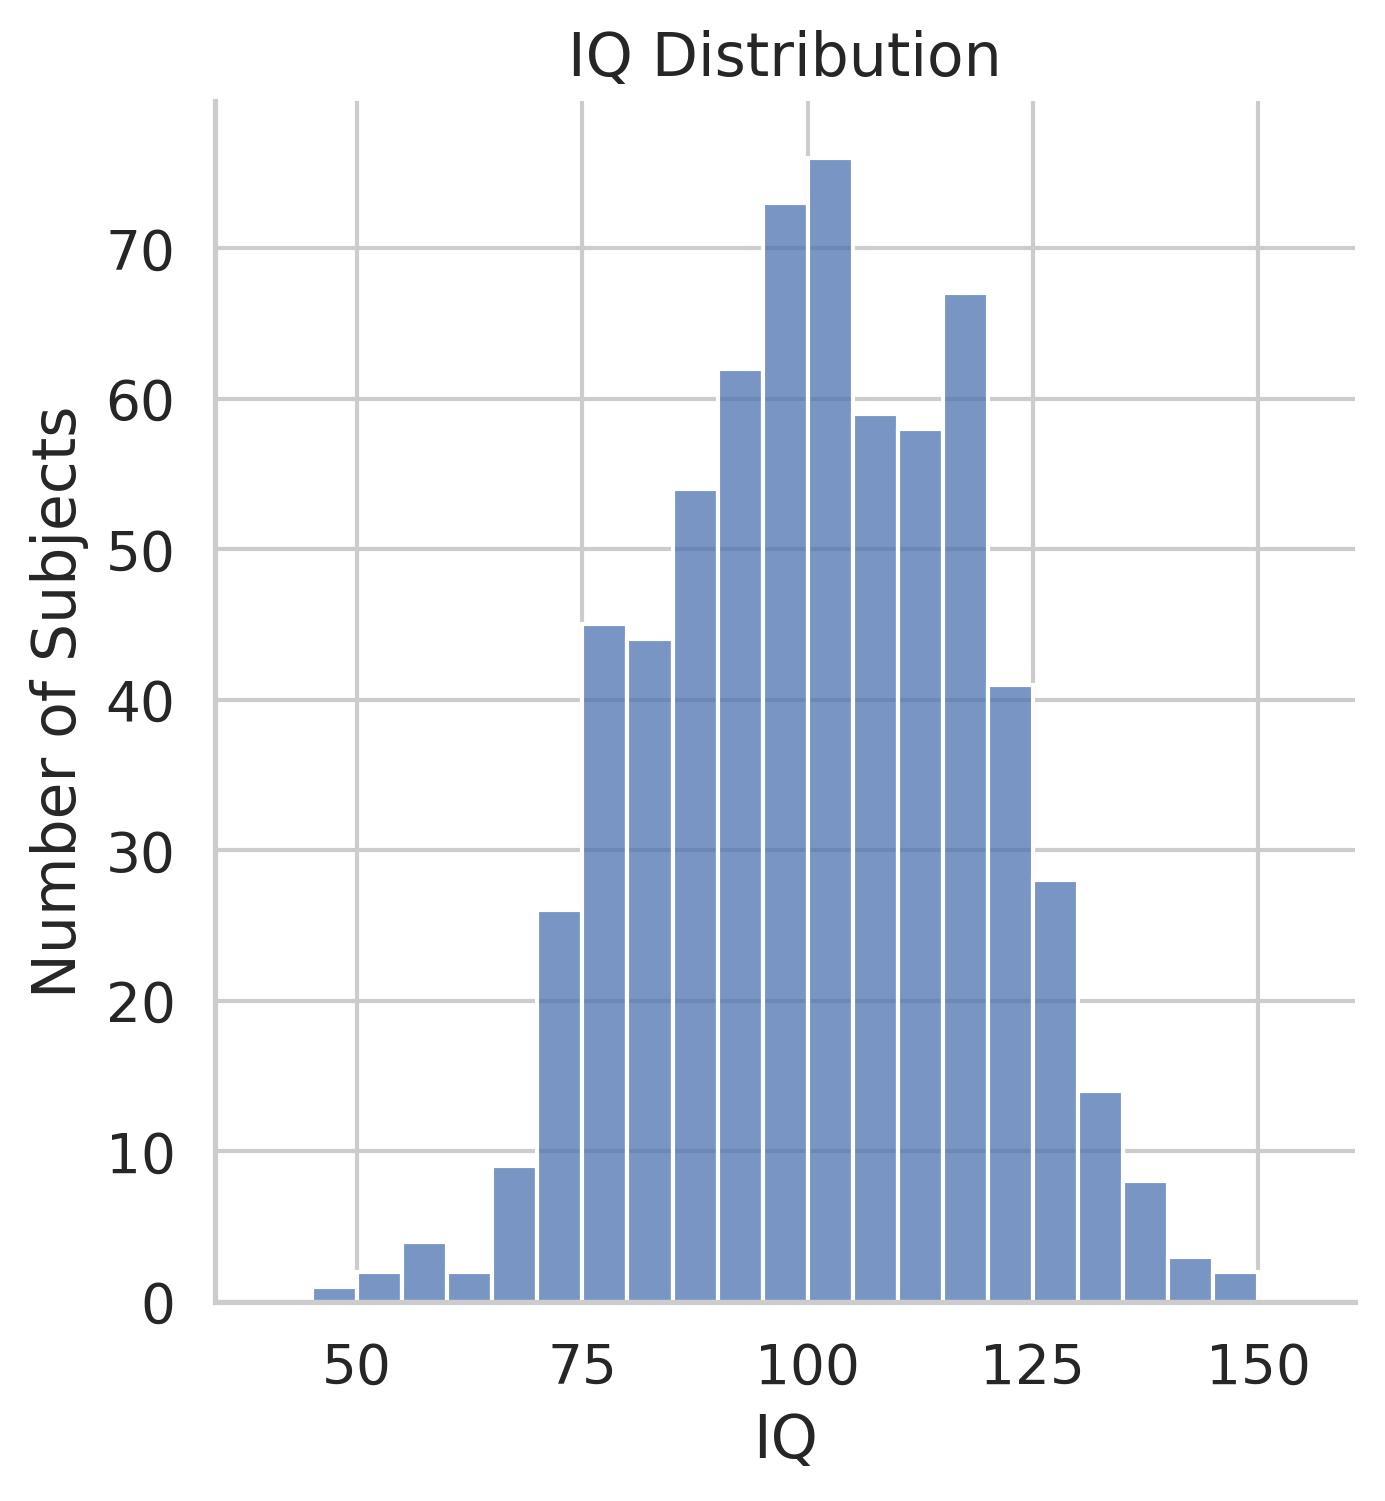

In [64]:
sns.displot(x=subjects_with_labels['assessment WISC,WISC_FSIQ'].astype(float), bins=range(40, 160, 5))
plt.title("IQ Distribution")
plt.xlabel('IQ')
plt.ylabel('Number of Subjects')
plt.show()

## Checks

### Check Subjects with Diagnosis

Diagnosis Status: [('No', 51), ('Unknown', 29), ('Yes', 594)]
Diagnosis: [('ADHD-Combined Type', 116), ('ADHD-Hyperactive/Impulsive Type', 17), ('ADHD-Inattentive Type', 153), ('Adjustment Disorders', 4), ('Autism Spectrum Disorder', 40), ('Borderline Intellectual Functioning', 3), ('Bulimia Nervosa', 1), ('Conduct Disorder-Childhood-onset type', 2), ('Cyclothymic Disorder', 1), ('Disruptive Mood Dysregulation Disorder', 3), ('Encopresis', 2), ('Enuresis', 10), ('Excoriation (Skin-Picking) Disorder', 2), ('Generalized Anxiety Disorder', 38), ('Intellectual Disability-Mild', 10), ('Intermittent Explosive Disorder', 1), ('Language Disorder', 10), ('Major Depressive Disorder', 16), ('No Diagnosis Given', 51), ('No Diagnosis Given: Incomplete Eval', 29), ('Obsessive-Compulsive Disorder', 7), ('Oppositional Defiant Disorder', 7), ('Other Specified Anxiety Disorder', 10), ('Other Specified Attention-Deficit/Hyperactivity Disorder', 21), ('Other Specified Depressive Disorder', 1), ('Other Spe

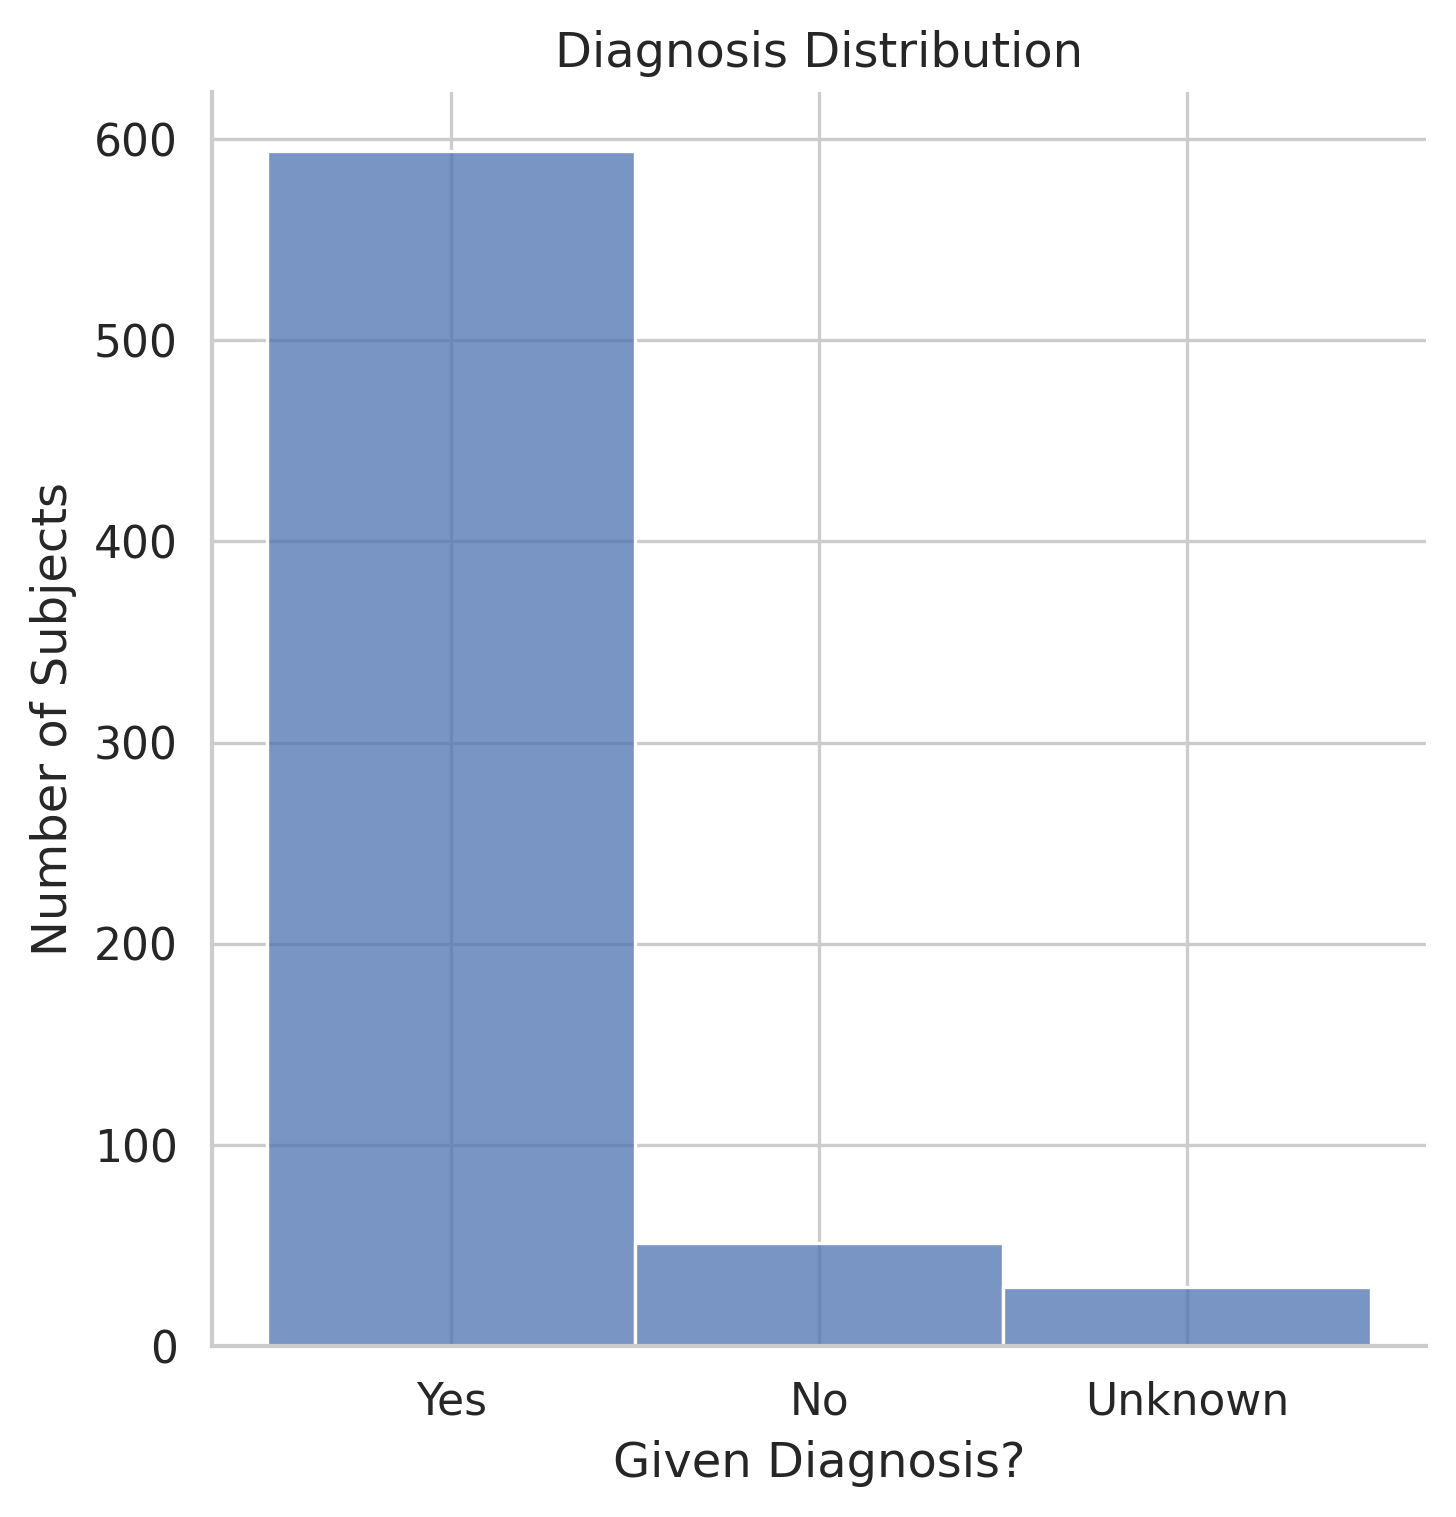

In [14]:
diagnosis_statuses = subjects_with_labels['assessment Diagnosis_ClinicianConsensus,NoDX']
unique, counts = np.unique(diagnosis_statuses, return_counts=True)
diagnosis_status = [(status, count) for status, count in zip(unique, counts)]
print("Diagnosis Status:", diagnosis_status)

diagnosises = subjects_with_labels['assessment Diagnosis_ClinicianConsensus,DX_01']
unique, counts = np.unique(diagnosises, return_counts=True)
diagnosis = [(status, count) for status, count in zip(unique, counts)]
print("Diagnosis:", diagnosis)

sns.displot(diagnosis_statuses)
plt.title("Diagnosis Distribution")
plt.xlabel('Given Diagnosis?')
plt.ylabel('Number of Subjects')
plt.show()

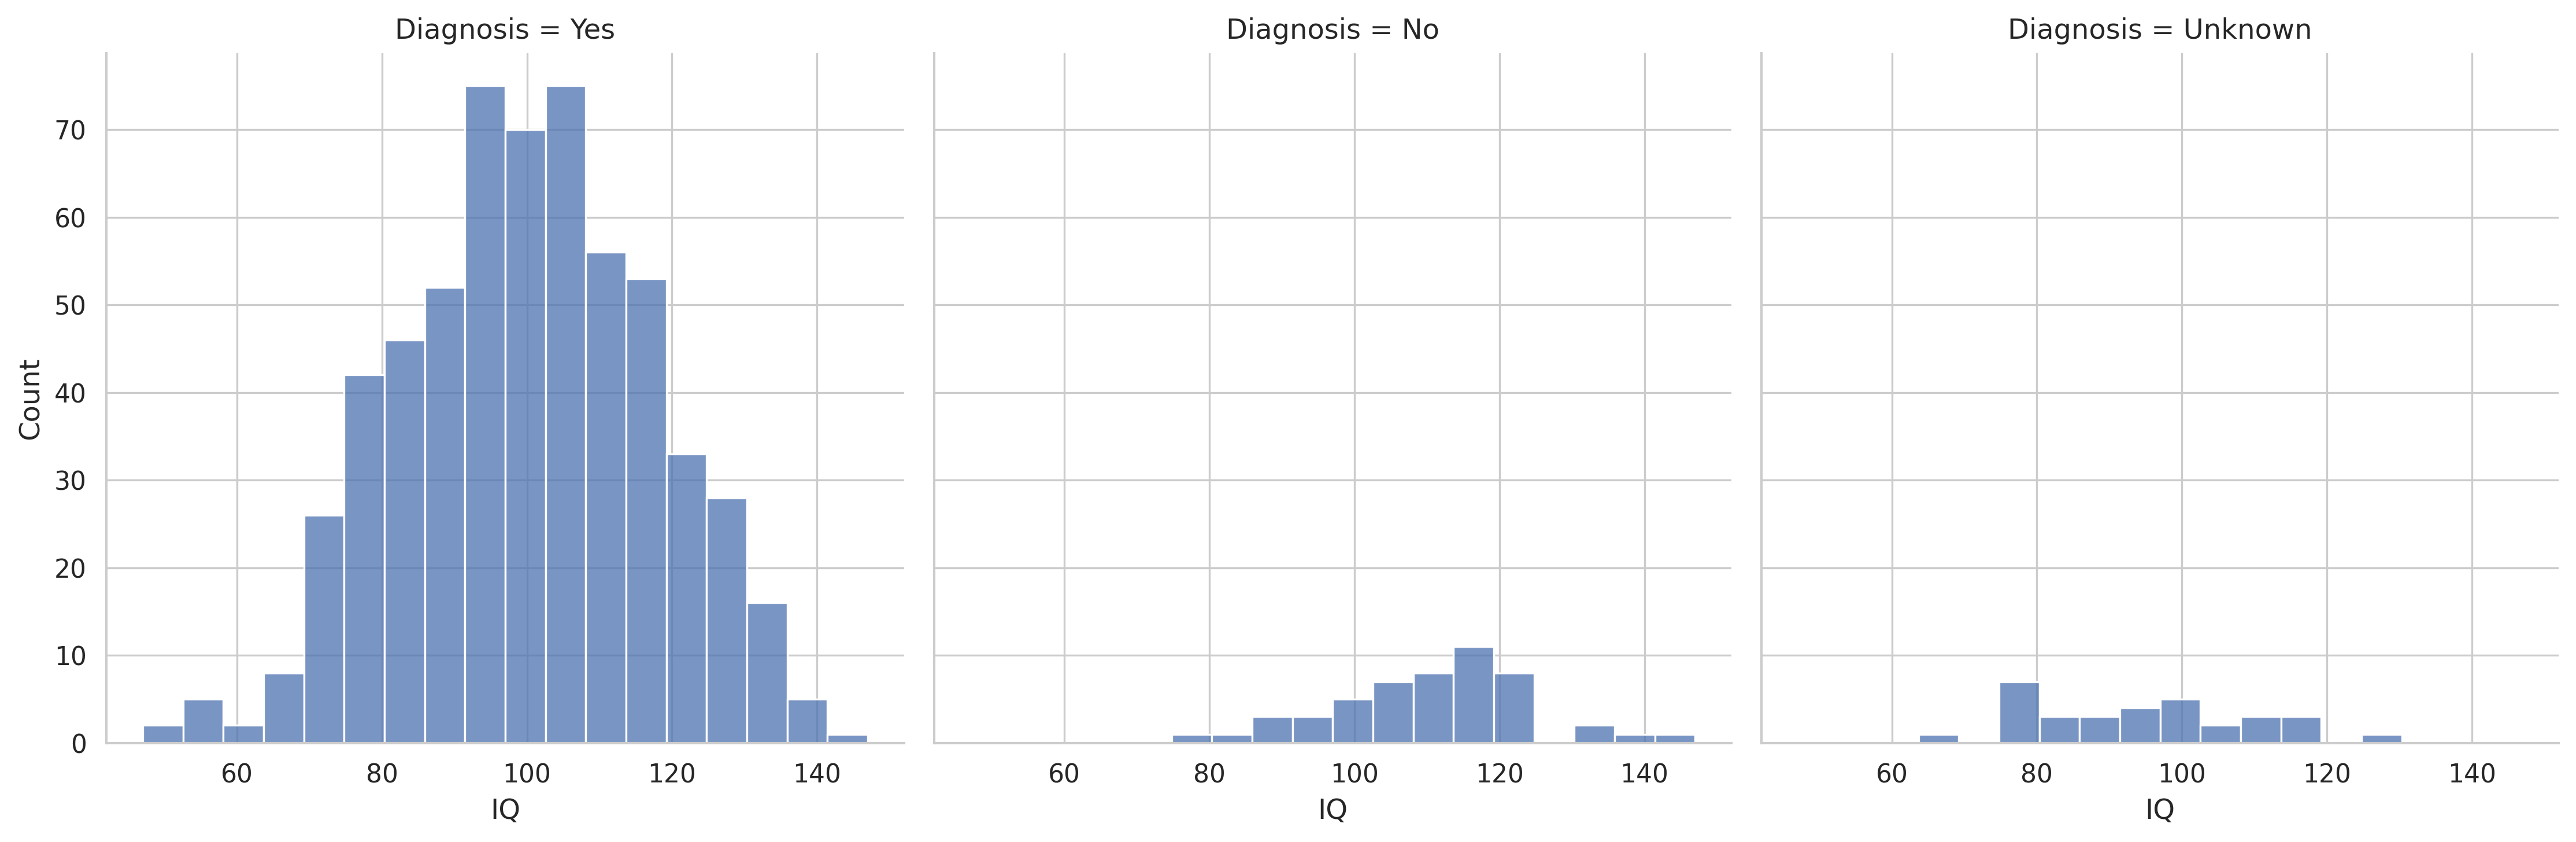

In [18]:
diagnosis_iq = subjects_with_labels[['assessment Diagnosis_ClinicianConsensus,NoDX', 
                                     'assessment WISC,WISC_FSIQ']]
diagnosis_iq = diagnosis_iq.rename(columns={'assessment Diagnosis_ClinicianConsensus,NoDX': 'Diagnosis',
                                    'assessment WISC,WISC_FSIQ': 'IQ'}, errors="raise")
diagnosis_iq['IQ'] = diagnosis_iq['IQ'].astype('int32')
# display(diagnosis_iq)

sns.displot(diagnosis_iq, x="IQ", col="Diagnosis", facet_kws=dict(margin_titles=True))

### Check WISC FSIQ

In [19]:
# Clean the original set of labels
clean_labels = labels[labels['assessment Basic_Demos,Age'] != "."]
clean_labels = clean_labels[clean_labels['assessment WISC,WISC_complete'] == '1']
clean_labels = clean_labels.dropna(axis='columns', how='all')

(2750,) (2750,) Avg IQ: 98.20472727272727
Slope: -0.69, r2: 0.01, p: 0.00


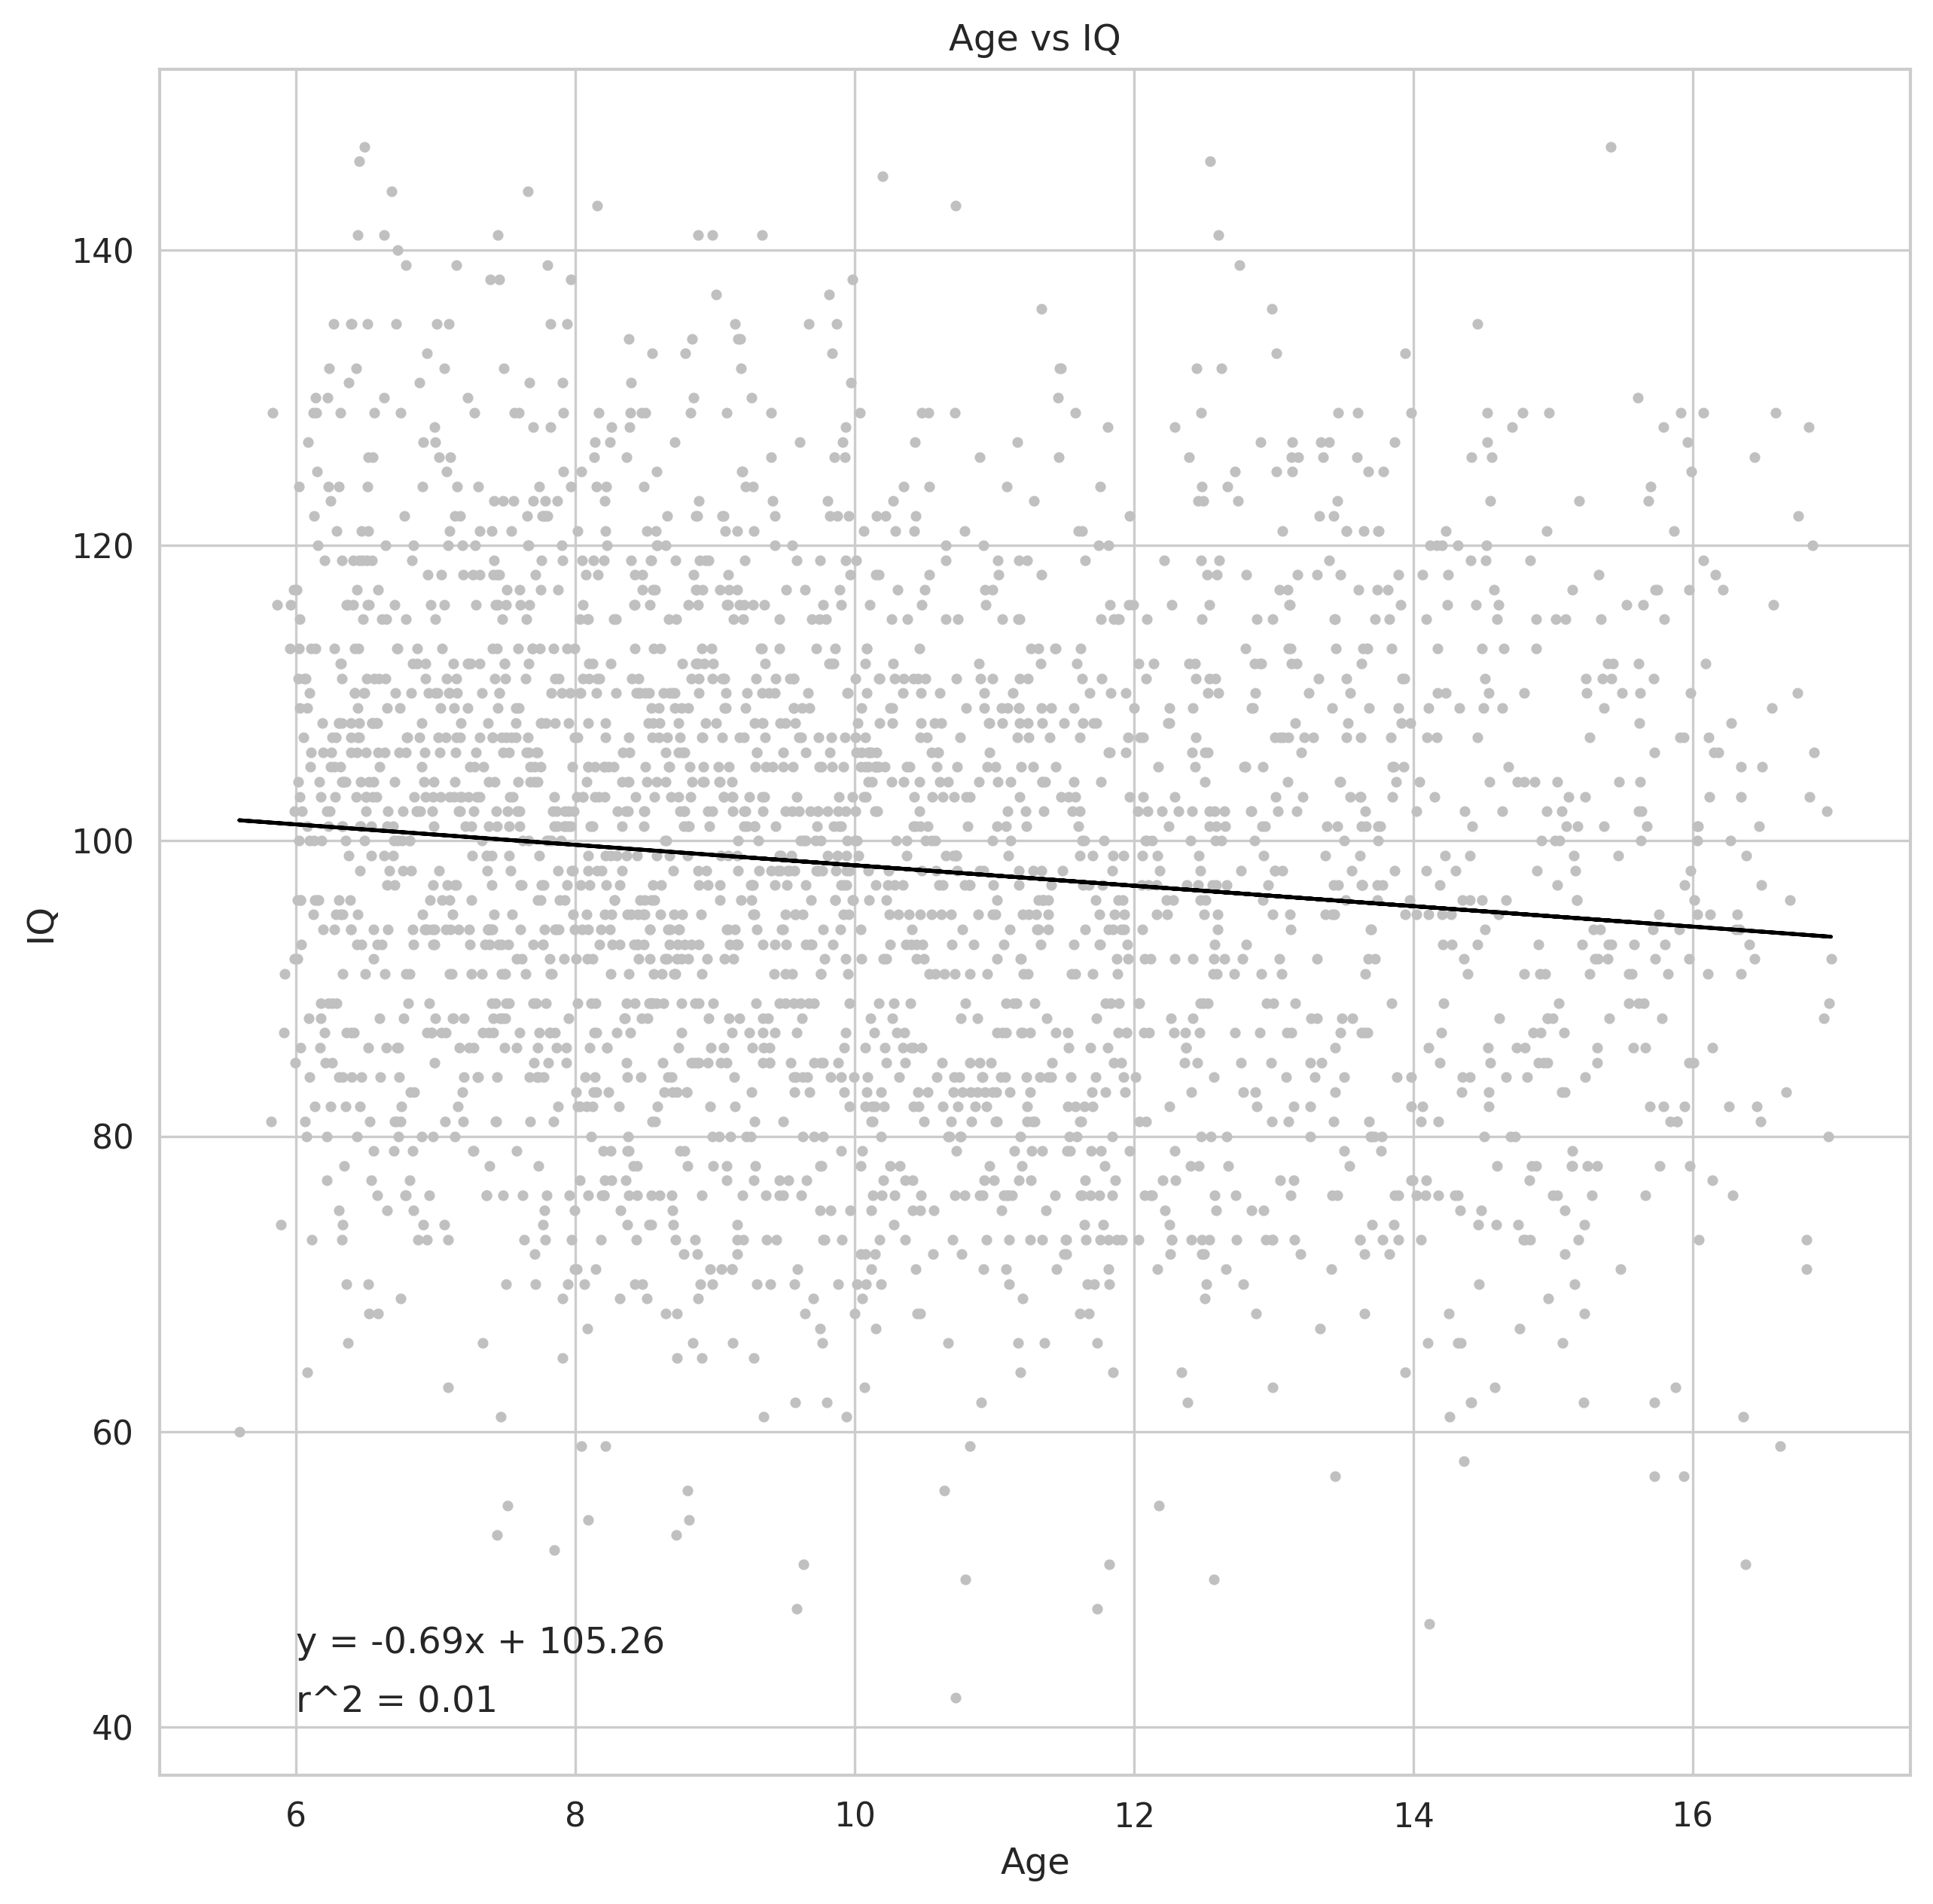

In [20]:
clean_labels = clean_labels.dropna(subset=['assessment WISC,WISC_FSIQ'])
wisc_fsiq = clean_labels['assessment WISC,WISC_FSIQ'].astype(int)
age = clean_labels['assessment Basic_Demos,Age'].astype(float)
print(age.shape, wisc_fsiq.shape, f"Avg IQ: {np.mean(wisc_fsiq)}")

m, b, r, p, stderr = stats.linregress(age, wisc_fsiq)
print(f"Slope: {m:.2f}, r2: {r**2:.2f}, p: {p:.2f}")

plt.plot(age, wisc_fsiq, '.', color='silver')
plt.plot(age, (m * age) + b, '-', color='black')
plt.title("Age vs IQ")
plt.xlabel('Age')
plt.ylabel('IQ')
plt.annotate(f"y = {m:.2f}x + {b:.2f}", (6, 45))
plt.annotate(f"r^2 = {r**2:.2f}", (6, 41))
plt.show()

### Check WISC subtests against age for scaling effects

In [12]:
# Grab columns
wisc_col = 'assessment WISC'
wisc_raw_measures = [
    'WISC_BD_Raw', 
    'WISC_Similarities_Raw', 
    'WISC_MR_Raw',
    'WISC_DS_Raw',
    'WISC_Coding_Raw',
    'WISC_Vocab_Raw',
    'WISC_FW_Raw',
    'WISC_VP_Raw',
    'WISC_PS_Raw',
    'WISC_SS_Raw',
]
wisc_scaled_measure = [
    'WISC_BD_Scaled', 
    'WISC_Similarities_Scaled', 
    'WISC_MR_Scaled',
    'WISC_DS_Scaled',
    'WISC_Coding_Scaled',
    'WISC_Vocab_Scaled',
    'WISC_FW_Scaled',
    'WISC_VP_Scaled',
    'WISC_PS_Scaled',
    'WISC_SS_Scaled',
]
wisc_measures = np.array([wisc_raw_measures, wisc_scaled_measure]).flatten('F')

clean_labels = clean_labels.dropna(subset=[f'assessment WISC,{measure}' for measure in wisc_measures])
wisc_measures_data = {measure: clean_labels[f'{wisc_col},{measure}'].astype(int).to_numpy() 
                      for measure in wisc_measures}
age = clean_labels['assessment Basic_Demos,Age'].astype(float)

print("Num WISC measures:", len(wisc_measures_data))
print("Num subjects:", len(age))

Num WISC measures: 20
Num subjects: 2734


In [14]:
for measure, data in wisc_measures_data.items():
    lin_reg = stats.linregress(age, data)
    print(f"{measure} r-squared:: {lin_reg.rvalue**2:.4f}")
    print(f"{measure} p-value: {lin_reg.pvalue}")
    print("--------------------------------------------")

WISC_BD_Raw r-squared:: 0.2690
WISC_BD_Raw p-value: 3.4735864988208293e-188
--------------------------------------------
WISC_BD_Scaled r-squared:: 0.0097
WISC_BD_Scaled p-value: 2.6293729163658773e-07
--------------------------------------------
WISC_Similarities_Raw r-squared:: 0.3797
WISC_Similarities_Raw p-value: 1.34023132102074e-285
--------------------------------------------
WISC_Similarities_Scaled r-squared:: 0.0125
WISC_Similarities_Scaled p-value: 4.376204194825878e-09
--------------------------------------------
WISC_MR_Raw r-squared:: 0.3045
WISC_MR_Raw p-value: 1.0965902551838532e-217
--------------------------------------------
WISC_MR_Scaled r-squared:: 0.0000
WISC_MR_Scaled p-value: 0.739732448678067
--------------------------------------------
WISC_DS_Raw r-squared:: 0.3099
WISC_DS_Raw p-value: 2.3167530683376688e-222
--------------------------------------------
WISC_DS_Scaled r-squared:: 0.0002
WISC_DS_Scaled p-value: 0.5069587352886207
-----------------------------